<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
from signal_loader import load_signals
import biosppy, pyhrv

import torch
import torch.nn.functional as F

import seaborn as sns
sns.set_theme()

Public MIT Supraventicular Arrythmia database https://physionet.org/content/svdb/1.0.0/


load_signals comes from private file

In [2]:
MITDB_PATH='Physionet/mitdb' 
mitdb = load_signals(MITDB_PATH, 'e')

records loaded: 48 from: Physionet/mitdb omitted files 0


In [97]:
def draw_peaks(title, signal, peak_loc, start_time, end_time, fs, c='r'):
    
    '''
    Parameters:
    title - string, title of graph
    signal - ecg signal values
    peak_loc - array of R peaks locations in signal (indices) 
    start_time - int, start on time axis for drawing graph in seconds, default 0
    end_time - int, end on time axis for drawing graph, default 5
    Fs - int, sampling frequency
    '''
    
    t = np.arange(0, signal.size/fs, 1./fs)  
    peak_val = signal[peak_loc]
   
    
    fig = plt.figure(figsize=(15,5)) 
    
    ax = fig.add_subplot(111)
        
    ax.axis([start_time, end_time, min(signal) - (max(signal) - min (signal))*0.1, max(signal) + (max(signal) - min (signal))*0.1])
    ax.set_title(title, fontsize = 22)
    ax.set_xlabel('Time [s]', fontsize = 18)
    ax.set_ylabel('Amplitude [-]', fontsize = 18)
    ax.plot(t, signal, c='tab:blue',lw=2)
    ax.plot(t[peak_loc], peak_val, c+'o')

In [5]:
def correct_peak_loc(signal):
    pred_peaks = biosppy.signals.ecg.correct_rpeaks(signal=signal['signal'], rpeaks=signal['peaks'], sampling_rate=signal['sampling_rate'])[0]
    
    if len(pred_peaks) != len(signal['peaks']):
        correct_indices = biosppy.ecg.compare_segmentation(pred_peaks, signal['peaks'], sampling_rate=signal['sampling_rate'], tol = 0.1)['match']
        p = [i for i, v in enumerate(signal['peaks'])]
        check = [el not in correct_indices for el in p]
        q = [i for i,v in enumerate(check) if not v]
        signal['peaks'][q] = pred_peaks
    else:
        signal['peaks'] = pred_peaks
        
    return signal

In [6]:
def same_padding(lin, stride, kernelsize):
    '''
    to achive padding that corresponds to mode 'same' in numpy convolve
    '''
    lout = lin
    return ((lout - 1)*stride - lin + kernelsize)/2

In [7]:
def convolve(signal, fil, stride):
    '''
    signal: ecg sraw signal
    fil: pattern for convolution, 'filter'
    stride: convolution parameter connected to smoothing of convolution
    '''
    signalt = torch.from_numpy(signal).float().view(1,1,-1)
    filt = torch.from_numpy(fil).view(1,1,-1)
    
    output = F.conv1d(input=signalt, weight=filt, stride=stride, padding=0)
    
    return output.numpy().ravel()

In [8]:
def resample_by_interpolation(signal, input_fs, output_fs):
    '''
    signal needs to be resampled to original frequency, bc of the convolution
    best to do so is by interpolation
    '''
    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    
    return resampled_signal

In [9]:
def normalize(a):
    return np.interp(a, (a.min(), a.max()), (0, +1))

In [107]:
import collections
from itertools import count


def explain_anomalies(y, resampled, peaks, fs, sigma=1.0):
    '''
    find anomalies on convolved signal by measuring the difference between samples
    (which peaks were 'intensified' after convolution)
    
    '''

    residual = y - resampled 
    
    # variation in the distribution
    std = np.std(residual)
    
    return [i for i in peaks if (y[i] > resampled[i] + (sigma*std)) | (y[i] < resampled[i] - (sigma*std))]
    
def explain_anomalies_rolling_std(y, resampled, peaks, fs, window_size, sigma=1.0):
    '''
    same as explain_anomalies but instead using std on whole signal it uses rolling std
    '''

    residual = y - resampled 
   
    testing_std = pd.Series(residual).rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, 
                                  testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    
    return [i for i in peaks if (y[i] > resampled[i] + (sigma*rolling_std[i])) | (y[i] < resampled[i] - (sigma*rolling_std[i]))]

In [108]:
def plot_anomalies(signal, sig_filt, peaks, fs, stride=20, window_size=None):
    '''
    plotting whole process
    '''

    if window_size is None:
        window_size = fs
        
    convolved = convolve(signal, sig_filt, stride) / sum(sig_filt)
    resampled = resample_by_interpolation(convolved, len(convolved)*fs/len(signal), fs)

    anomal_peaks = explain_anomalies_rolling_std(signal, resampled, peaks, fs, window_size)

    fig, ax = plt.subplots(3, 2, figsize=(16, 10))
    axi = ax.ravel()
    axi[0].plot(sig_filt)
    axi[0].set_title('QRS')
    axi[1].plot(signal)
    axi[1].set_title('Original signal')
    axi[2].plot(convolved)
    axi[2].set_title('Convolution of QRS complex with signa;')
    axi[3].plot(resampled)
    axi[3].set_title('Convolution resampled by interpolation')
    axi[4].plot(signal)
    axi[4].plot(resampled)
    axi[4].set_title('Difference between original and resampled convolution signal')
    axi[5].plot(signal)
    axi[5].scatter(anomal_peaks, signal[anomal_peaks], c='r')
    axi[5].set_title('Marked anomaly peaks')
    
    

In [79]:
def get_interval_peaks(peaks, start_time, end_time, fs):
    '''
    we plot only for part of the signal to visualize process
    get peaks that corresponds to the interval
    '''
    idx_start = (np.abs(peaks - start_time*fs)).argmin() 
    idx_end = (np.abs(peaks - end_time*fs)).argmin() 
    return peaks[idx_start:idx_end]

In [105]:
def output(instance, pattern, start_time, end_time, stride=10):
    '''
    calculates important data and plotting the process
    '''
    fs = instance['sampling_rate']
    peaks = get_interval_peaks(instance['peaks'], start_time, end_time, fs)
    peaks_corrected_idx = peaks - (start_time*fs)
    plot_anomalies(instance['signal'][start_time*fs : end_time*fs], pattern, peaks_corrected_idx, fs, stride, 360)

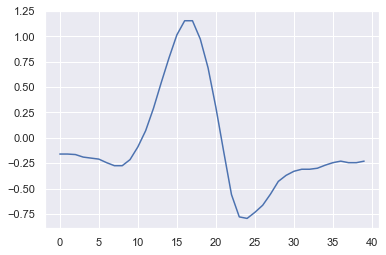

In [48]:
# pretty QRS complex
QRS_pattern = mitdb[30]['signal'][16230:16270]
plt.plot(QRS_pattern)

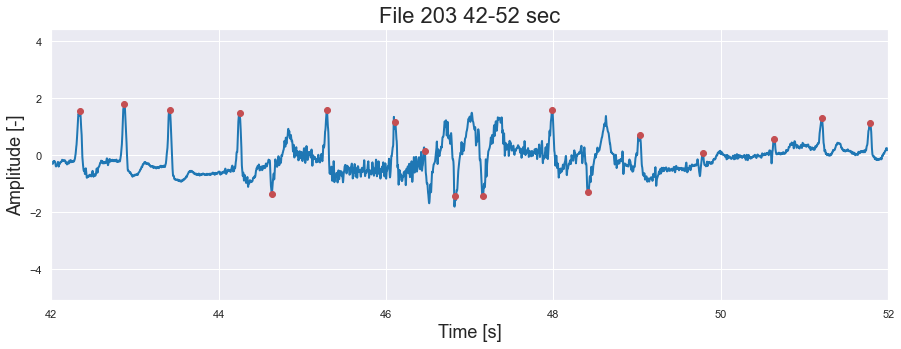

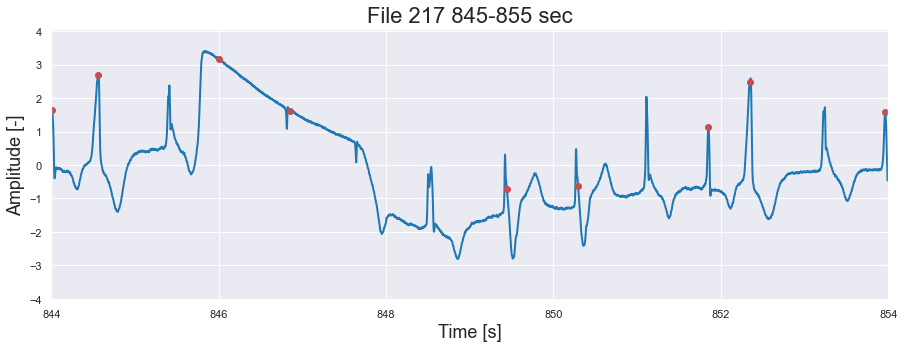

In [57]:
# locate ugly fragments of signals
draw_peaks('File 203 42-52 sec', mitdb[26]['signal'], mitdb[26]['peaks'], 42, 52, fs)
draw_peaks('File 217 845-855 sec', mitdb[36]['signal'], mitdb[36]['peaks'], 844, 854, fs)

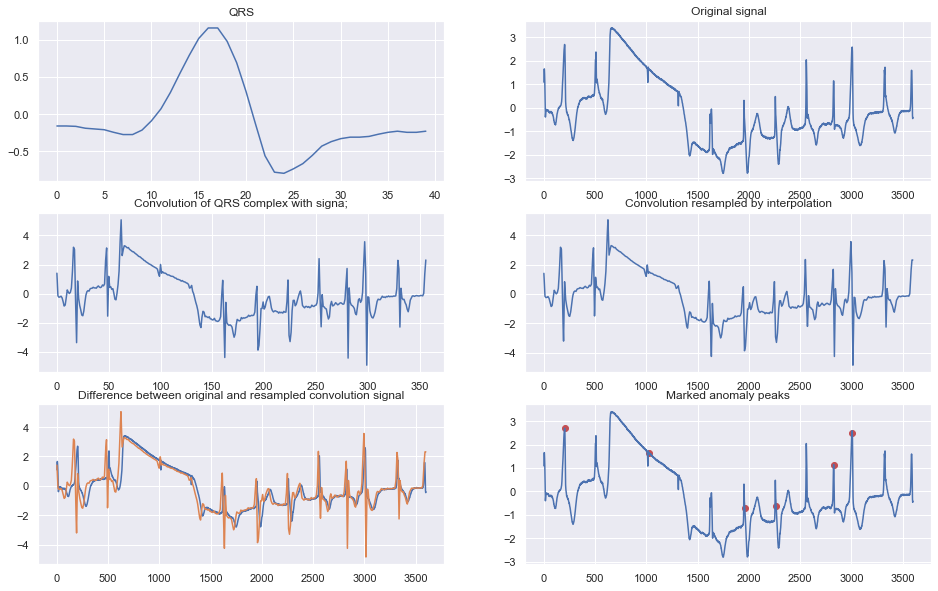

In [109]:
output(mitdb[36], QRS_pattern, 844, 854)

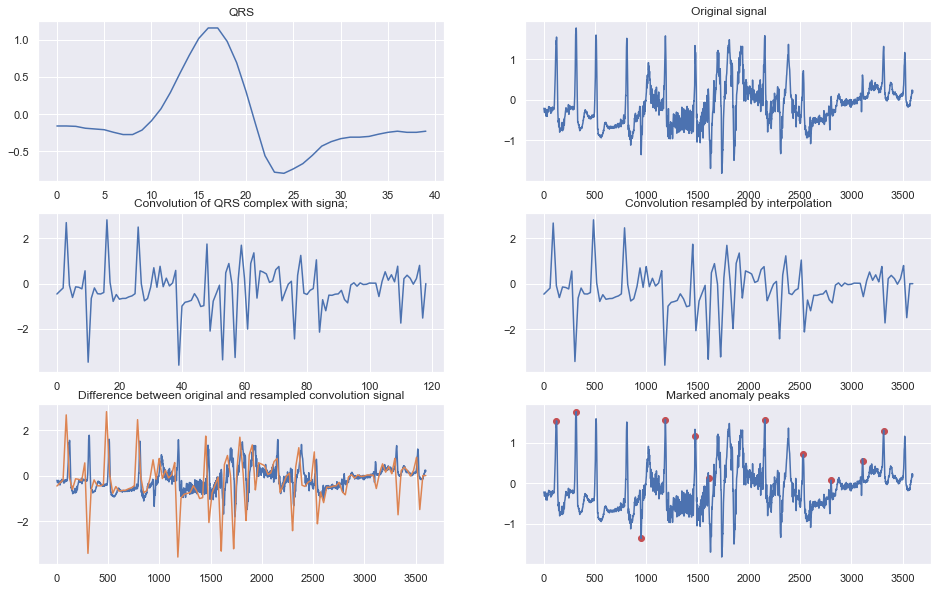

In [110]:
output(mitdb[26], QRS_pattern, 42, 52, 30)